In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/predict-energy-behavior-of-prosumers/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv
/kaggle/input/predict-energy-behavior-of-prosumers/public_timeseries_testing_util.py
/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/county_id_to_name_map.json
/kaggle/input/predict-energy-behavior-of-prosumers/train.csv
/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/sample_submission.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/electricity

In [2]:
# Define the dataset path
path_dataset = '/kaggle/input/predict-energy-behavior-of-prosumers'

# Loading the datasets
train = pd.read_csv(os.path.join(path_dataset, 'train.csv'))
historical_weather = pd.read_csv(os.path.join(path_dataset, 'historical_weather.csv'))

In [3]:
# Define a function to process the holiday DataFrame for a given year
def get_holidays(year):
    # Fetch holidays from the website
    url = f'https://www.timeanddate.com/holidays/estonia/{year}?hol=1'
    df = pd.read_html(url)[0]
    # Flatten the MultiIndex columns if present
    df.columns = df.columns.get_level_values(0)
    # Select the desired columns
    df = df[['Date', 'Name', 'Type']]
    # Filter for national holidays only
    df = df[df['Type'] == 'National holiday']
    # Add a 'Year' column to differentiate between years
    df['Year'] = year
    
    try:
        # Create a new column combining 'Date' and 'Year' for datetime conversion
        df['date'] = pd.to_datetime(df['Date'] + ' ' + df['Year'].astype(str))
    except:
        # Apply the function to the "Date" column
        df['Date'] = df['Date'].apply(replace_month_name)
        df['date'] = pd.to_datetime(df['Date'] + ' ' + df['Year'].astype(str))

    df = df[['date', 'Name', 'Type']]
    
    return df

# Function to replace abbreviated month names with full names
def replace_month_name(date):
    # Create a dictionary to map abbreviated month names to full names
    month_mapping = {
        'jan': 'January',
        'feb': 'February',
        'apr': 'April',
        'mei': 'May',
        'jun': 'June',
        'aug': 'August',
        'dec': 'December'
    }
    parts = date.split()
    if len(parts) == 2:
        day, month = parts
        if month.lower() in month_mapping:
            return f"{day} {month_mapping[month.lower()]}"
    return date

# Get holidays for 2022 and 2023
df_holiday_2022 = get_holidays(2022)
df_holiday_2023 = get_holidays(2023)

# Concatenate the DataFrames
df_holiday = pd.concat([df_holiday_2022, df_holiday_2023], ignore_index=True)

df_holiday

date                          Name              Type
0  2022-01-01                New Year's Day  National holiday
1  2022-02-24              Independence Day  National holiday
2  2022-04-15                   Good Friday  National holiday
3  2022-04-17                 Easter Sunday  National holiday
4  2022-05-01                     Labor Day  National holiday
5  2022-06-05                     Pentecost  National holiday
6  2022-06-23                   Victory Day  National holiday
7  2022-06-24                 Midsummer Day  National holiday
8  2022-08-20  Independence Restoration Day  National holiday
9  2022-12-24                 Christmas Eve  National holiday
10 2022-12-25                 Christmas Day  National holiday
11 2022-12-26                    Boxing Day  National holiday
12 2023-01-01                New Year's Day  National holiday
13 2023-02-24              Independence Day  National holiday
14 2023-04-07                   Good Friday  National holiday
15 2023-04-09                 Easter Sunday  National holiday
16 2023-05-01                     Labor Day  National holiday
17 2023-05-28                     Pentecost  National holiday
18 2023-06-23                   Victory Day  National holiday
19 2023-06-24                 Midsummer Day  National holiday
20 2023-08-20  Independence Restoration Day  National holiday
21 2023-12-24                 Christmas Eve  National holiday
22 2023-12-25                 Christmas Day  National holiday
23 2023-12-26                    Boxing Day  National holiday

In [4]:
# Pivot the training data to have a cleaner DataFrame where we can analyze the mean target values
# organized by datetime and various categorical variables.
pivot_train = train.pivot_table(index='datetime',columns=['county','product_type','is_business','is_consumption'], values='target', aggfunc='mean')

# Renaming columns for easier access and interpretation
pivot_train.columns = ['county{}_productType{}_isBusiness{}_isConsumption{}'.format(*col) for col in pivot_train.columns.values]
pivot_train.head() # Display the first few rows of the pivoted train data

county0_productType0_isBusiness1_isConsumption0  \
datetime                                                               
2021-09-01 00:00:00                                              0.0   
2021-09-01 01:00:00                                              0.0   
2021-09-01 02:00:00                                              0.0   
2021-09-01 03:00:00                                              0.0   
2021-09-01 04:00:00                                              0.0   

                     county0_productType0_isBusiness1_isConsumption1  \
datetime                                                               
2021-09-01 00:00:00                                             59.0   
2021-09-01 01:00:00                                             61.6   
2021-09-01 02:00:00                                             63.1   
2021-09-01 03:00:00                                             64.0   
2021-09-01 04:00:00                                             60.5   

                     county0_productType1_isBusiness0_isConsumption0  \
datetime                                                               
2021-09-01 00:00:00                                            0.713   
2021-09-01 01:00:00                                            1.132   
2021-09-01 02:00:00                                            0.490   
2021-09-01 03:00:00                                            0.496   
2021-09-01 04:00:00                                            0.149   

                     county0_productType1_isBusiness0_isConsumption1  \
datetime                                                               
2021-09-01 00:00:00                                           96.590   
2021-09-01 01:00:00                                           77.691   
2021-09-01 02:00:00                                           91.594   
2021-09-01 03:00:00                                           87.955   
2021-09-01 04:00:00                                           88.184   

                     county0_productType1_isBusiness1_isConsumption0  \
datetime                                                               
2021-09-01 00:00:00                                              0.0   
2021-09-01 01:00:00                                              0.0   
2021-09-01 02:00:00                                              0.0   
2021-09-01 03:00:00                                              0.0   
2021-09-01 04:00:00                                              0.0   

                     county0_productType1_isBusiness1_isConsumption1  \
datetime                                                               
2021-09-01 00:00:00                                          501.760   
2021-09-01 01:00:00                                          486.297   
2021-09-01 02:00:00                                          458.562   
2021-09-01 03:00:00                                          511.794   
2021-09-01 04:00:00                                          520.318   

                     county0_productType2_isBusiness0_isConsumption0  \
datetime                                                               
2021-09-01 00:00:00                                              0.0   
2021-09-01 01:00:00                                              0.0   
2021-09-01 02:00:00                                              0.0   
2021-09-01 03:00:00                                              0.0   
2021-09-01 04:00:00                                              0.0   

                     county0_productType2_isBusiness0_isConsumption1  \
datetime                                                               
2021-09-01 00:00:00                                           17.314   
2021-09-01 01:00:00                                           15.872   
2021-09-01 02:00:00                                           16.510   
2021-09-01 03:00:00                                           14.271   
2021-09-01 04:00:00                                   

In [5]:
# Pivoting the historical weather data similarly to have mean temperature and shortwave radiation per datetime
pivot_historical_weather = historical_weather.pivot_table(index='datetime', values=['temperature','shortwave_radiation'], aggfunc='mean')
pivot_historical_weather.head() # Display the first few rows of the pivoted historical weather data

shortwave_radiation  temperature
datetime                                             
2021-09-01 00:00:00                  0.0    13.441071
2021-09-01 01:00:00                  0.0    13.290179
2021-09-01 02:00:00                  0.0    13.199107
2021-09-01 03:00:00                  0.0    13.104464
2021-09-01 04:00:00                  0.0    12.986607

In [6]:
# Merging the pivoted training and historical weather data
train_data = pivot_train.merge(pivot_historical_weather, left_index=True, right_index=True)

# Converting index to datetime for better manipulation and merging with holiday data
train_data.index = pd.to_datetime(train_data.index)
train_data['date'] = pd.to_datetime(train_data.index.date)
train_data = train_data.reset_index().merge(df_holiday, on='date', how='left')
train_data = train_data.set_index('datetime')
train_data = train_data.loc['2022-07':] # Focusing on data from July 2022 onwards

train_data.head() # Display the first few rows of the merged training data

county0_productType0_isBusiness1_isConsumption0  \
datetime                                                               
2022-07-01 00:00:00                                              0.0   
2022-07-01 01:00:00                                              0.0   
2022-07-01 02:00:00                                              0.0   
2022-07-01 03:00:00                                              0.0   
2022-07-01 04:00:00                                              0.6   

                     county0_productType0_isBusiness1_isConsumption1  \
datetime                                                               
2022-07-01 00:00:00                                           245.06   
2022-07-01 01:00:00                                           242.20   
2022-07-01 02:00:00                                           241.46   
2022-07-01 03:00:00                                           231.54   
2022-07-01 04:00:00                                           223.08   

                     county0_productType1_isBusiness0_isConsumption0  \
datetime                                                               
2022-07-01 00:00:00                                            0.724   
2022-07-01 01:00:00                                            0.589   
2022-07-01 02:00:00                                            1.243   
2022-07-01 03:00:00                                            0.920   
2022-07-01 04:00:00                                            3.074   

                     county0_productType1_isBusiness0_isConsumption1  \
datetime                                                               
2022-07-01 00:00:00                                          304.117   
2022-07-01 01:00:00                                          256.060   
2022-07-01 02:00:00                                          234.613   
2022-07-01 03:00:00                                          209.147   
2022-07-01 04:00:00                                          186.839   

                     county0_productType1_isBusiness1_isConsumption0  \
datetime                                                               
2022-07-01 00:00:00                                            0.000   
2022-07-01 01:00:00                                            0.000   
2022-07-01 02:00:00                                            0.000   
2022-07-01 03:00:00                                            0.000   
2022-07-01 04:00:00                                            0.277   

                     county0_productType1_isBusiness1_isConsumption1  \
datetime                                                               
2022-07-01 00:00:00                                          581.778   
2022-07-01 01:00:00                                          544.147   
2022-07-01 02:00:00                                          534.357   
2022-07-01 03:00:00                                          509.002   
2022-07-01 04:00:00                                          470.774   

                     county0_productType2_isBusiness0_isConsumption0  \
datetime                                                               
2022-07-01 00:00:00                                             0.00   
2022-07-01 01:00:00                                             0.00   
2022-07-01 02:00:00                                             0.00   
2022-07-01 03:00:00                                             0.00   
2022-07-01 04:00:00                                             0.06   

                     county0_productType2_isBusiness0_isConsumption1  \
datetime                                                               
2022-07-01 00:00:00                                           13.137   
2022-07-01 01:00:00                                            9.203   
2022-07-01 02:00:00                                            7.596   
2022-07-01 03:00:00                                            8.469   
2022-07-01 04:00:00                                   

In [7]:
# Exploring correlations among features, focusing on daily means
corr_daily_mean = train_data.select_dtypes('float').resample('D').mean().corr()

# Isolating and sorting the correlation of other features with temperature
corr_temperature = corr_daily_mean['temperature'].sort_values(ascending=False)
corr_temperature = corr_temperature.drop('temperature')
corr_temperature

county4_productType1_isBusiness1_isConsumption0     0.787891
county0_productType2_isBusiness0_isConsumption0     0.745074
county13_productType1_isBusiness0_isConsumption0    0.713367
county2_productType3_isBusiness1_isConsumption0     0.692282
shortwave_radiation                                 0.684514
                                                      ...   
county14_productType1_isBusiness0_isConsumption1   -0.941527
county15_productType1_isBusiness0_isConsumption1   -0.942151
county8_productType1_isBusiness0_isConsumption1    -0.942937
county11_productType1_isBusiness0_isConsumption1   -0.946676
county0_productType1_isBusiness0_isConsumption1    -0.952199
Name: temperature, Length: 139, dtype: float64

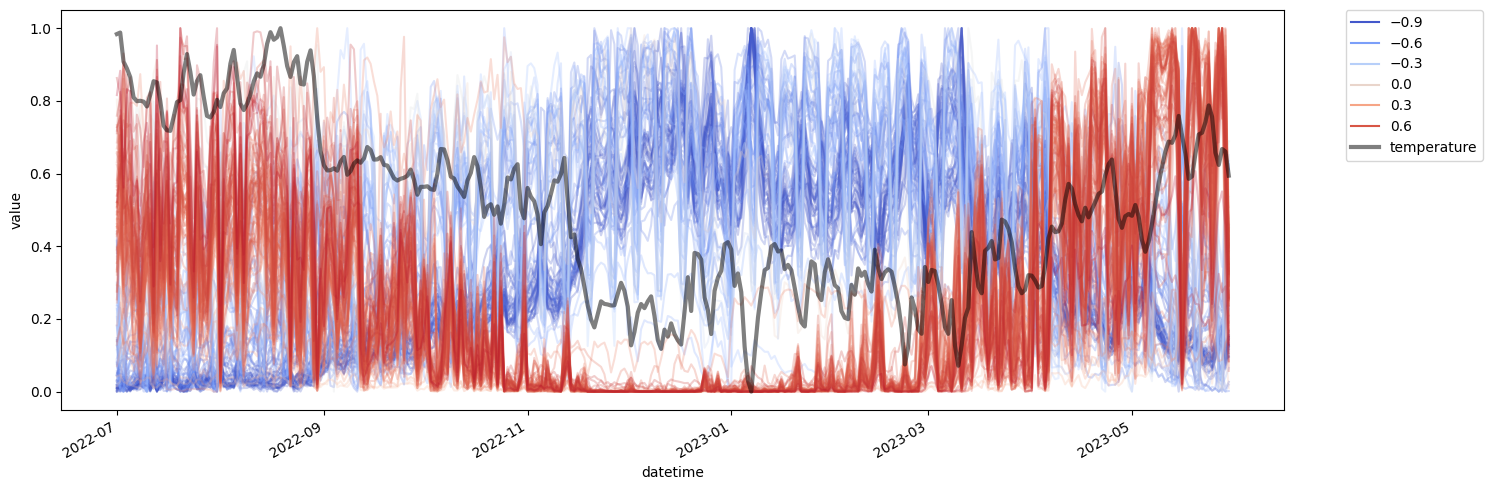

In [8]:
df_plot = train_data[corr_temperature.index]
df_plot.columns = corr_temperature.to_list()

# Resampling data to daily frequency and calculating the mean to smooth out the fluctuations
df_plot = df_plot.resample('D').mean()

# Normalizing data to bring all variables to a common scale without distorting differences in the ranges of values
df_plot = (df_plot - df_plot.min()) / (df_plot.max() - df_plot.min())

# Dropping columns with all NaN values that may have appeared after resampling
df_plot = df_plot.dropna(axis=1)

# Resetting index to convert 'datetime' from index to a column suitable for seaborn's lineplot function
df_plot = df_plot.reset_index()

# Melting the dataframe to transform it into a long format for plotting with seaborn
df_plot = df_plot.melt(var_name='corr', id_vars='datetime')


# Set the size of your figure
plt.figure(figsize=(15, 5))

# Create the initial lineplot with the coolwarm colormap and transparency.
ax = sns.lineplot(
    data=df_plot,
    x="datetime",
    y="value",
    hue="corr",
    palette="coolwarm",  # Sets the "coolwarm" color map for the hue.
    alpha=0.25  # Sets the transparency of the lines.
)

# Calculate the resampled mean of 'temperature' on a daily basis
# and plot it on the same Axes instance `ax` with a bold line
weather_plot = train_data['temperature'].resample('D').mean()
weather_plot = (weather_plot-weather_plot.min())/(weather_plot.max()-weather_plot.min())
weather_plot.plot(ax=ax, linewidth=3, color='black',alpha=0.5)

# Put the legend outside the figure/plot. Note that this will include legends for both plots.
# If you wish to have a legend only for the first plot, you can handle legend creation manually.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

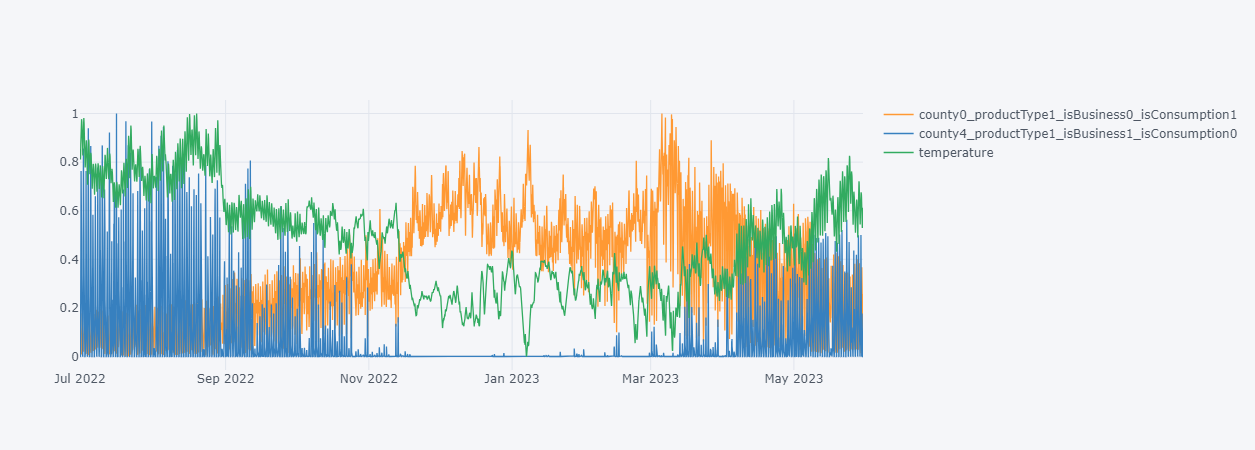

In [9]:
df_plot = train_data[[corr_temperature.index[-1],corr_temperature.index[0],'temperature']]
df_plot = (df_plot-df_plot.min())/(df_plot.max()-df_plot.min())
df_plot.iplot()

In [10]:
corr_radiation = corr_daily_mean['shortwave_radiation'].drop(['temperature','shortwave_radiation']).sort_values(ascending=False)
corr_radiation

county14_productType2_isBusiness1_isConsumption0    0.958344
county14_productType1_isBusiness0_isConsumption0    0.951448
county9_productType1_isBusiness1_isConsumption0     0.946213
county7_productType1_isBusiness0_isConsumption0     0.943897
county3_productType3_isBusiness1_isConsumption0     0.934923
                                                      ...   
county0_productType2_isBusiness1_isConsumption1    -0.822577
county0_productType1_isBusiness1_isConsumption1    -0.823099
county11_productType2_isBusiness1_isConsumption1   -0.832745
county3_productType3_isBusiness1_isConsumption1    -0.836181
county3_productType1_isBusiness1_isConsumption1    -0.857160
Name: shortwave_radiation, Length: 138, dtype: float64

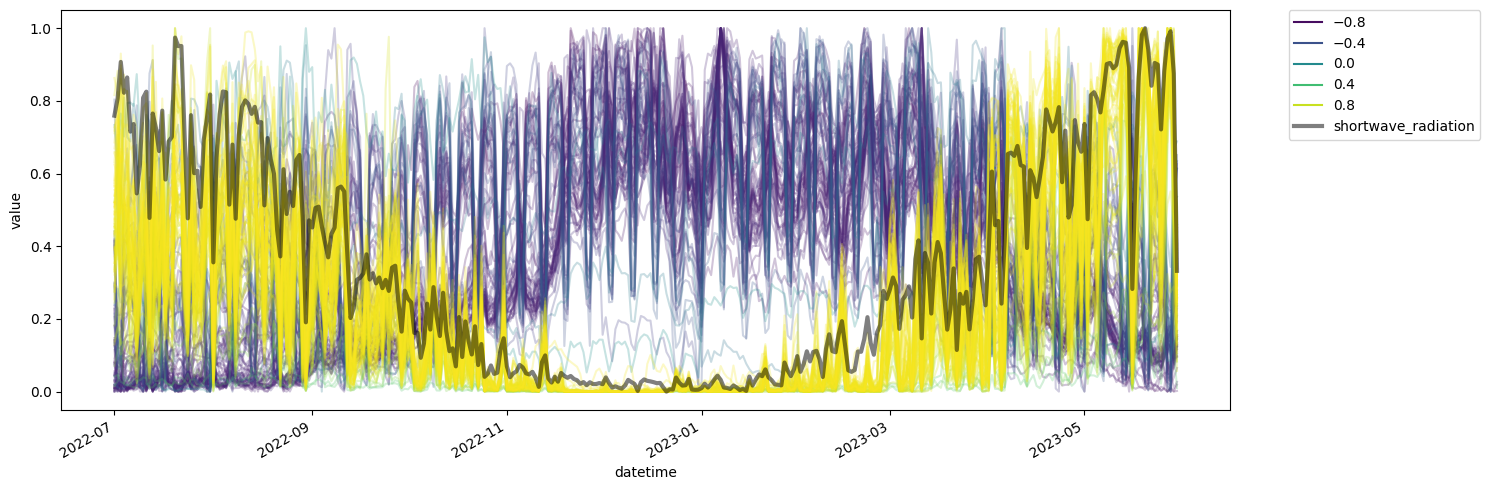

In [11]:
df_plot = train_data[corr_radiation.index]
df_plot.columns = corr_radiation.to_list()
df_plot = df_plot.resample('D').mean()
df_plot = (df_plot-df_plot.min())/(df_plot.max()-df_plot.min())
df_plot = df_plot.dropna(axis=1)
df_plot = df_plot.reset_index()
df_plot = df_plot.melt(var_name='corr',id_vars='datetime')

# Set the size of your figure
plt.figure(figsize=(15, 5))

# Create the lineplot with the coolwarm colormap and transparency.
ax = sns.lineplot(
    data=df_plot,
    x="datetime",
    y="value",
    hue="corr",
    palette="viridis",  # Sets the "coolwarm" color map for the hue.
    alpha=0.25  # Sets the transparency of the lines.
)

# Calculate the resampled mean of 'temperature' on a daily basis
# and plot it on the same Axes instance `ax` with a bold line
weather_plot = train_data['shortwave_radiation'].resample('D').mean()
weather_plot = (weather_plot-weather_plot.min())/(weather_plot.max()-weather_plot.min())
weather_plot.plot(ax=ax, linewidth=3, color='black',alpha=0.5)


# Put the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Optional: Adjust the layout so that the legend does not cut off
plt.tight_layout()

# To display the plot
plt.show()

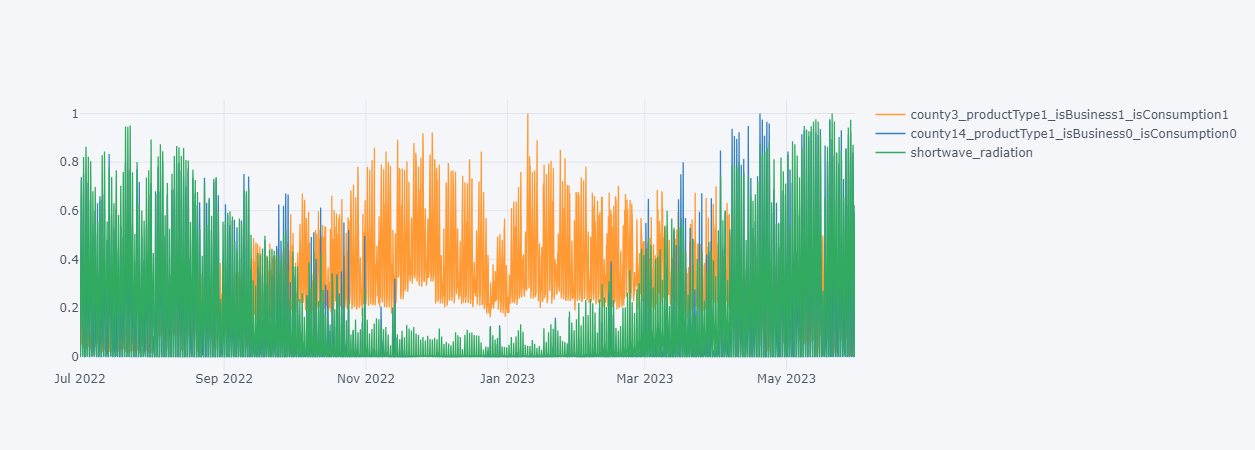

In [12]:
df_plot = train_data[[corr_radiation.index[-1],corr_radiation.index[1],'shortwave_radiation']]
df_plot = (df_plot-df_plot.min())/(df_plot.max()-df_plot.min())
df_plot.iplot()

<Axes: xlabel='datetime'>

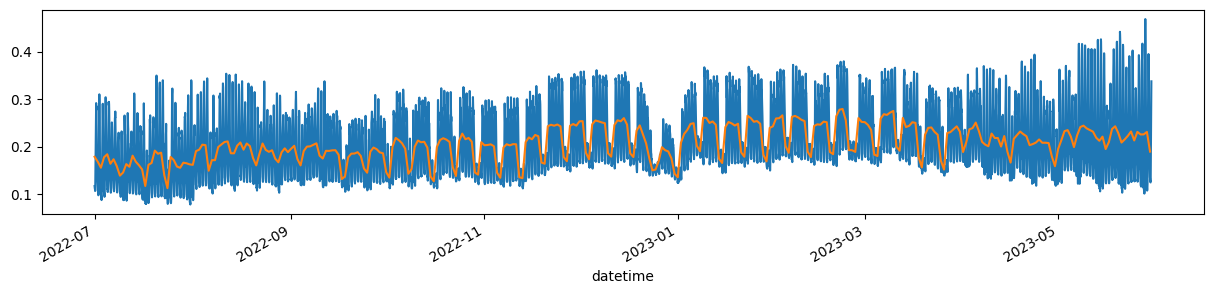

In [13]:
df_plot = train_data.loc[:, train_data.columns.str.contains('isBusiness1')]
df_plot = (df_plot-df_plot.min())/(df_plot.max()-df_plot.min())
df_plot = df_plot.mean(axis=1)
df_plot.plot(figsize=(15,3))
df_plot.resample('D').mean().plot(figsize=(15,3))

In [14]:
df_plot = df_plot.rename('target').to_frame()

df_plot['hour'] = df_plot.index.hour
df_plot['weekday'] = df_plot.index.weekday
df_plot['timeofweek'] = df_plot['weekday']*24 + df_plot['hour']

In [15]:
plt.figure(figsize=(8, 3))
sns.lineplot(data=df_plot, x="hour", y="target")
plt.show()

plt.figure(figsize=(8, 3))
sns.lineplot(data=df_plot, x="timeofweek", y="target")
plt.show()

In [16]:
df_plot['day_type'] = 'Regular days'
df_plot.loc[df_plot['weekday']>4, 'day_type'] = 'Weekends'
df_plot.loc[train_data['Type']=='National holiday', 'day_type'] = 'National holiday'

df_plot['day_name'] = df_plot['day_type'].copy()
df_plot.loc[~train_data['Name'].isna(), 'day_name'] = train_data.loc[~train_data['Name'].isna(), 'Name']

In [17]:
plt.figure(figsize=(8, 3))
sns.boxplot(data=df_plot, x="weekday", y="target")
plt.show()

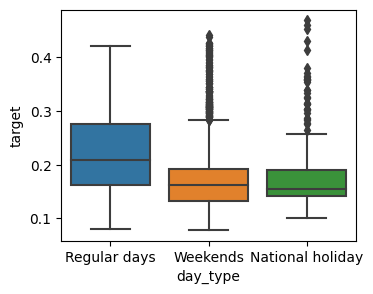

In [18]:
plt.figure(figsize=(3.8, 3))
sns.boxplot(data=df_plot, x="day_type", y="target")
plt.show()

In [19]:
ts_plot = df_plot.pivot_table(columns='day_type', index='datetime', values='target')
ts_plot[['Regular days','Weekends','National holiday']].iplot()

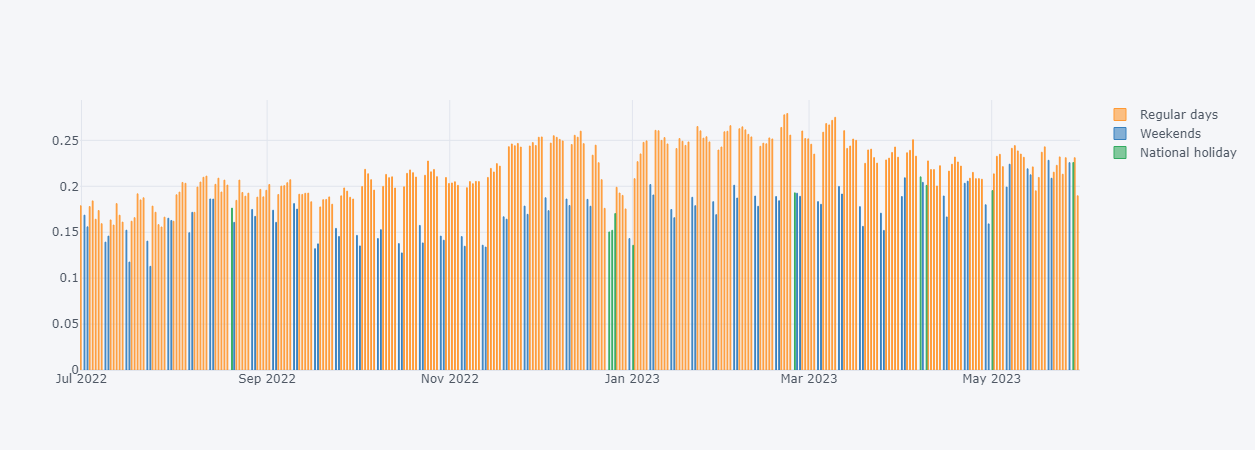

In [20]:
ts_plot[['Regular days','Weekends','National holiday']].resample('D').mean().iplot(kind='bar')